In [8]:
import os
from typing import TypedDict
from IPython.display import display, Markdown

from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.messages import BaseMessage, HumanMessage

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_ollama import ChatOllama

In [9]:
# --- 1. Define the Model ---
os.environ.setdefault("no_proxy", "127.0.0.1,localhost")
os.environ.setdefault("HTTPX_NO_PROXY", "127.0.0.1,localhost")
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://127.0.0.1:11434")

model_name = "llama3.2:3b"
max_tokens = 100
llm = ChatOllama(model=model_name, base_url=OLLAMA_URL, num_predict=max_tokens, temperature=0.5)

In [10]:
# --- 2. Define the Shared State ---
class AgentState(TypedDict):
    user_request: str
    plan: str
    code: str
    review: str
    revision_number: int

In [11]:
# --- 3. Define the Agents (as Graph Nodes) ---


# Node 1: The Planner
def planner_node(state: AgentState):
    print("--- 📋 PLANNER: Creating plan... ---")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a software architect. Create a detailed technical plan for the user's request. Be specific about the tech stack, API endpoints, and data models. Do not write code.",
            ),
            ("human", "User Request: {user_request}"),
        ]
    )
    chain = prompt | llm
    plan = chain.invoke({"user_request": state["user_request"]}).content
    return {"plan": plan}


# Node 2: The Coder
def coder_node(state: AgentState):
    print(f"--- 💻 CODER: Writing code (Attempt #{state['revision_number']})... ---")

    system_prompt_str = "You are an expert Python developer specializing in the Flask framework. Write clean, functional, and correct Python code based on the provided plan."

    if state["revision_number"] > 1:
        system_prompt_str += "\n\nThe previous code was reviewed with the following feedback: {review}\n\nPlease revise the code to address this feedback."

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_prompt_str), ("human", "Technical Plan:\n{plan}")]
    )

    chain_inputs = {"plan": state["plan"]}
    if state["revision_number"] > 1:
        chain_inputs["review"] = state["review"]

    chain = prompt_template | llm
    code = chain.invoke(chain_inputs).content

    formatted_code = f"```python\n{code}\n```"

    next_revision_number = state["revision_number"] + 1

    return {"code": formatted_code, "revision_number": next_revision_number}


# Node 3: The Reviewer (PROMPT IMPROVED)
def reviewer_node(state: AgentState):
    print("--- 🔍 REVIEWER: Reviewing code... ---")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a senior software engineer. Review the following Python code for correctness, style (PEP 8), and potential bugs.

        You MUST end your review with one of the two exact phrases below, on a new line:
        VERDICT: APPROVED
        VERDICT: NEEDS_REVISION

        Example of a good review:
        "The code looks good, but the variable name `x` is not descriptive. VERDICT: NEEDS_REVISION"
        """,
            ),
            ("human", "Code to Review:\n{code}"),
        ]
    )
    chain = prompt | llm
    review = chain.invoke({"code": state["code"]}).content
    return {"review": review}


# --- 4. Define Conditional Logic (LOGIC IMPROVED) ---
def should_continue(state: AgentState):
    print("--- 🧭 DECISION: Checking review verdict... ---")
    review_text = state[
        "review"
    ].upper()  # Convert to uppercase for a case-insensitive check

    if "VERDICT: APPROVED" in review_text:
        print("✅ Review approved. Ending workflow.")
        return "end"
    elif "VERDICT: NEEDS_REVISION" in review_text:
        print("❌ Review needs revision. Sending back to coder.")
        return "revise"
    else:
        # Fallback: If the LLM fails to follow the format, assume revision to avoid an infinite loop of confusion.
        print("⚠️ Reviewer did not provide a clear verdict. Assuming revision needed.")
        return "revise"

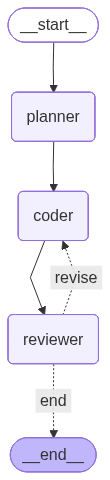

In [12]:
# --- 5. Build the Graph ---
workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_node)
workflow.add_node("coder", coder_node)
workflow.add_node("reviewer", reviewer_node)

workflow.set_entry_point("planner")
workflow.add_edge("planner", "coder")
workflow.add_edge("coder", "reviewer")

workflow.add_conditional_edges(
    "reviewer",
    should_continue,
    {
        "end": END,
        "revise": "coder"
    }
)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [13]:
# --- 6. Run the System ---
if __name__ == "__main__":
    user_request = "Create a simple Flask API for a to-do list. It should use an in-memory list to store tasks. Each task should have an ID and a title. It needs endpoints to get all tasks and add a new task."

    config = {"configurable": {"thread_id": "1"}}

    print("🚀 Starting LangGraph Multi-Agent Code Generation Workflow...")
    print(f"👤 User Request: \"{user_request}\"")
    print("="*50)

    initial_state = {
        "user_request": user_request,
        "plan": "",
        "code": "",
        "review": "",
        "revision_number": 1
    }

    # --- Add a recursion limit as a safety net ---
    recursion_limit = 10

    try:
        for event in app.stream(initial_state, config, recursion_limit=recursion_limit):
            for node_name, node_output in event.items():
                print(f"--- Finished Node: {node_name} ---")

        final_state = app.get_state(config)

        print("\n" + "="*50)
        print("✅ WORKFLOW COMPLETE")
        print("="*50)

        print("\n--- 📋 FINAL PLAN ---")
        print(display(Markdown(final_state.values.get('plan'))))

        print("\n--- 💻 FINAL CODE ---")
        print(display(Markdown(final_state.values.get('code'))))

        print("\n--- 🔍 FINAL REVIEW ---")
        print(display(Markdown(final_state.values.get('review'))))

        final_revisions = final_state.values.get('revision_number') - 1
        print(f"\n--- 📈 TOTAL REVISIONS: {final_revisions} ---")

    except Exception as e:
        print(f"\n❌ Workflow failed or hit recursion limit: {e}")
        # to see what went wrong.
        final_state = app.get_state(config)
        print("\n--- Last Generated Code ---")
        print(display(Markdown(final_state.values.get('code'))))
        print("\n--- Last Review ---")
        print(display(Markdown(final_state.values.get('review'))))

🚀 Starting LangGraph Multi-Agent Code Generation Workflow...
👤 User Request: "Create a simple Flask API for a to-do list. It should use an in-memory list to store tasks. Each task should have an ID and a title. It needs endpoints to get all tasks and add a new task."
--- 📋 PLANNER: Creating plan... ---
--- Finished Node: planner ---
--- 💻 CODER: Writing code (Attempt #1)... ---
--- Finished Node: coder ---
--- 🔍 REVIEWER: Reviewing code... ---
--- 🧭 DECISION: Checking review verdict... ---
⚠️ Reviewer did not provide a clear verdict. Assuming revision needed.
--- Finished Node: reviewer ---
--- 💻 CODER: Writing code (Attempt #2)... ---
--- Finished Node: coder ---
--- 🔍 REVIEWER: Reviewing code... ---
--- 🧭 DECISION: Checking review verdict... ---
⚠️ Reviewer did not provide a clear verdict. Assuming revision needed.
--- Finished Node: reviewer ---
--- 💻 CODER: Writing code (Attempt #3)... ---
--- Finished Node: coder ---
--- 🔍 REVIEWER: Reviewing code... ---
--- 🧭 DECISION: Checking r

```python
Here is the revised code based on the provided technical plan:

```python
from flask import Flask, jsonify, request
import sqlite3
from typing import List

app = Flask(__name__)

# Connect to SQLite database. It will be created if it doesn't exist.
def get_db_connection():
    conn = sqlite3.connect('todo.db')
    conn.row_factory = sqlite3.Row
    return conn

class Task:
    """
    Represents a task with its id, title, and status
```

None

--- Last Review ---


Here's the review of the provided code:

The code looks good overall. However, there are a few areas that can be improved for better style and adherence to PEP 8 guidelines.

1. Inconsistent indentation: The docstring for the `Task` class is not indented correctly. It should start with four spaces.

2. Missing import statement: There's an import statement missing for the `jsonify` function from Flask. It should be added as follows:

   ```python
from

None
